# Global Liquid Natural Gas Trend Analysis and Production Forecasting

## Import Modules

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Get Data
This dataset contains Production of Natural Gas Liquids by end use from 1990-2022 according to the United Nations Statistics Division.

Source:
https://datasource.kapsarc.org/explore/dataset/production-of-natural-gas-liquids-by-end-use/information

In [210]:
file_path= r'production-of-natural-gas-liquids-by-end-use.csv'
cols= ['REF_AREA','TRANSACTION', 'year','OBS_VALUE']
dtype= {'REF_AREA':'string', 'TRANSACTION':'string', 'year':np.int16, 'OBS_VALUE':np.int32}
sep=';'
df= pd.read_csv(
                file_path, sep=sep,
                usecols=cols,
                dtype=dtype
                )
df

,REF_AREA,TRANSACTION,year,OBS_VALUE
0,Afghanistan,Transformation,1990,0
1,Afghanistan,Other transformation,1991,0
2,Afghanistan,Total energy supply,1991,3
3,Afghanistan,Total energy supply,1992,0
4,Algeria,Production,1992,20830
...,...,...,...,...
12004,Indonesia,Imports,2009,59
12005,Indonesia,Imports,2012,0
12006,Indonesia,Exports,1994,3899
12007,Indonesia,Exports,1995,4285


## Functions

In [211]:
def processing_steps(df):
    '''
    Normalise cases and filter for redundant transaction types.
    Params: df
    Returns: df with affected changes
    '''
    df.columns= [column.lower() for column in df.columns]
    df = df[df['year'] < 2023]
    return df
def print_dataframe_details(df):
    '''
    Return Summary Statisitics of a dataframe
    Params: df
    Returns: Shape, Columns, Info, Missing values, Sample rows, Unique values in each column
    '''
    
    try:
        print(f'Dataset Shape:{df.shape}')
        print(f'\n Columns:{df.columns.tolist()}')
        print(f'\n Info:\n{df.info()}')
        print(f'\n Missing values:\n{df.isnull().sum()}')
        print(f'\n Sample rows:\n{df.head(10)}')
        print(f'\n Duplicate rows:\n{df.duplicated().sum()}')
        print('\n \n')
        print('UNIQUE VALUES IN EACH COLUMN')
        for column in df.columns:
            print(column, df[column].unique())
    except Exception as e:
        return print('Could not get dataframe details, error:',e)
    
    return print('DATA SUMMARY COMPLETED')
    
def transaction_partition(df):
    '''
    '''
    dataframes_by_transaction={}
    for transaction in df['transaction'].unique():
        dataframes_by_transaction[transaction]= df[df['transaction'] == transaction].copy()
    for dataframe in dataframes_by_transaction.values():
        dataframe.drop(columns=['transaction'], inplace=True, errors='ignore')
    return dataframes_by_transaction

In [212]:
df= processing_steps(df)

### Transaction Types In The Dataset
The three largest classes of transaction are:
1. Total energy supply → Net supply available in a country after accounting for imports, exports, production, and stock changes

2. Production → Total amount of natural gas liquids (NGLs) produced in a given year/country.

3. Transformation → NGLs used to generate other forms of energy (e.g., electricity, heat, or refined fuels). 

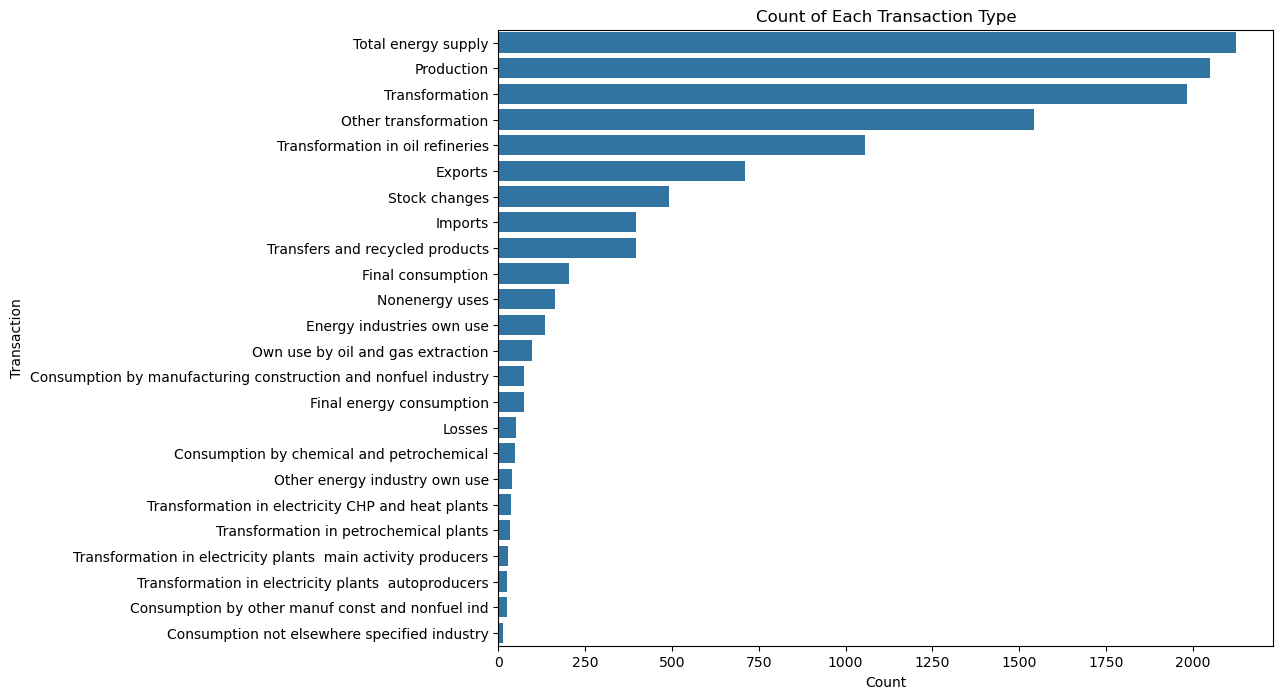

In [213]:
plt.figure(figsize=(10,8))
sns.countplot(
    data=df[df['transaction'].isin(df['transaction'].value_counts().index)],
    y='transaction',
    order=df['transaction'].value_counts()[lambda x: x > 10].index
)
plt.title('Count of Each Transaction Type')
plt.xlabel('Count')
plt.ylabel('Transaction')
plt.show()

This analysis will focus on total energy supply, transformation and production after the dataset has been partitioned by transaction.

In [214]:
dataframes_by_transaction= transaction_partition(df)

## Net Energy Supply Breakdown
Total energy supply refers to the net supply available in a country after accounting for imports, exports, production, and stock changes. For example, Algeria's total energy supply in 1998 was 9889 metric tonnes.

In [215]:
# Get total energy supply dataframe from dataframes_by_transaction dictionary
df_total_energy_supply= dataframes_by_transaction['Total energy supply']
df_total_energy_supply

,ref_area,year,obs_value
2,Afghanistan,1991,3
3,Afghanistan,1992,0
48,Algeria,1993,5681
49,Algeria,1998,9889
50,Algeria,2004,10354
...,...,...,...
11943,Greece,1997,22
11944,Greece,1999,1
11945,Greece,2007,7
11986,Hungary,2016,242


In [216]:
print_dataframe_details(df_total_energy_supply)

Dataset Shape:(2126, 3)

 Columns:['ref_area', 'year', 'obs_value']
<class 'pandas.core.frame.DataFrame'>
Index: 2126 entries, 2 to 12001
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ref_area   2126 non-null   string
 1   year       2126 non-null   int16 
 2   obs_value  2126 non-null   int32 
dtypes: int16(1), int32(1), string(1)
memory usage: 45.7 KB

 Info:
None

 Missing values:
ref_area     0
year         0
obs_value    0
dtype: int64

 Sample rows:
       ref_area  year  obs_value
2   Afghanistan  1991          3
3   Afghanistan  1992          0
48      Algeria  1993       5681
49      Algeria  1998       9889
50      Algeria  2004      10354
51      Algeria  2005       9837
52      Algeria  2006       8547
53      Algeria  2010      12526
54      Algeria  2013      10321
55      Algeria  2015      13466

 Duplicate rows:
0

 

UNIQUE VALUES IN EACH COLUMN
ref_area <StringArray>
[                               

In [217]:
supp_by_year= df_total_energy_supply.groupby('year')['obs_value'].sum()

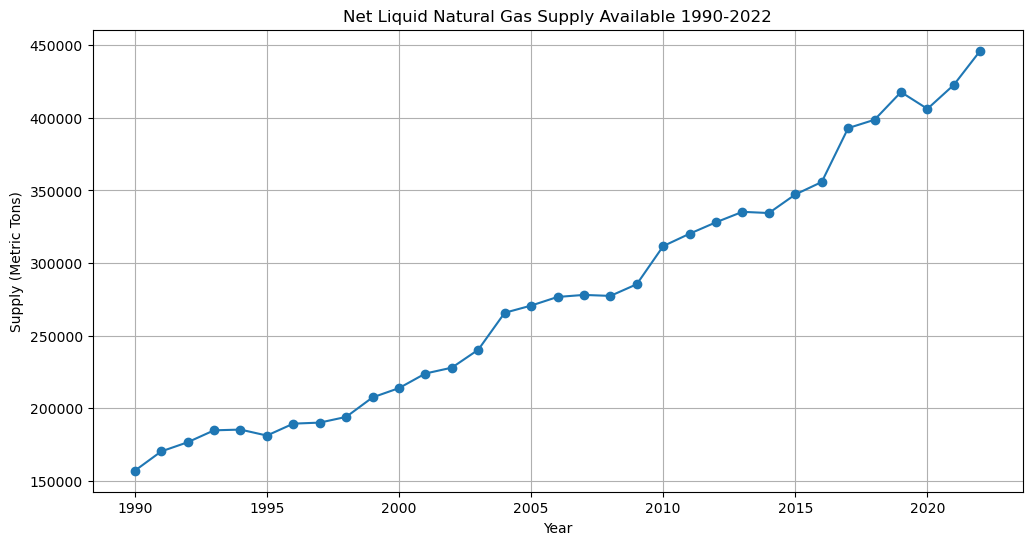

In [218]:
plt.figure(figsize=(12, 6))
plt.plot(supp_by_year.index, supp_by_year.values, marker='o')
plt.title('Net Liquid Natural Gas Supply Available 1990-2022')
plt.xlabel('Year')
plt.ylabel('Supply (Metric Tons)')
plt.grid(True)
plt.show()

In [219]:
global_supp= df_total_energy_supply.groupby(['year','ref_area'])['obs_value'].sum().reset_index()
top5supp_countries = (
    global_supp.groupby('ref_area')['obs_value']
    .sum()
    .nlargest(5)            # get top 5
    .index
)
top5_supp = global_supp[global_supp['ref_area'].isin(top5supp_countries)]

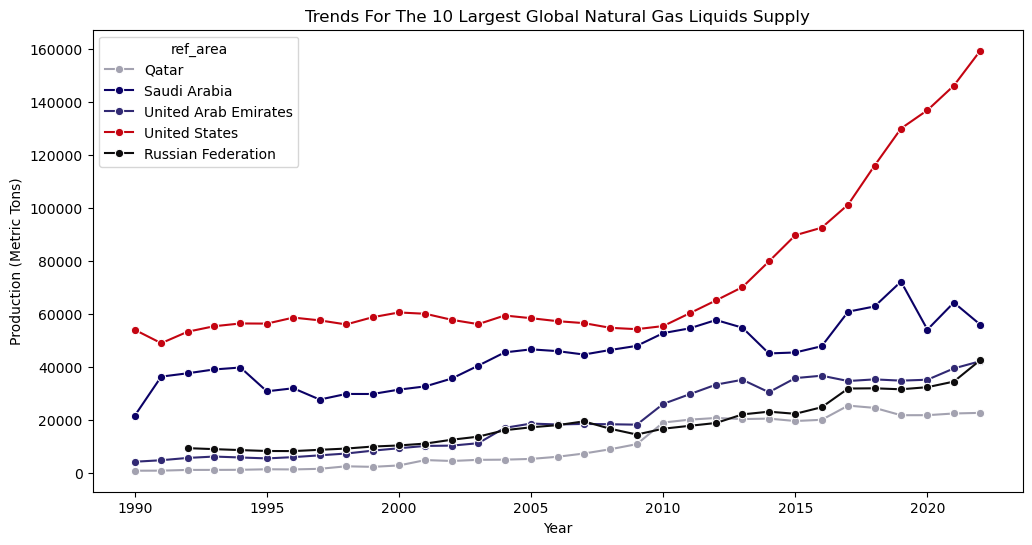

In [220]:
palette=['#a3a2b0', '#0b0166', '#312973', '#c40411', '#0d0c0d']
plt.figure(figsize=(12,6))
sns.lineplot(data=top5_supp, x='year', y='obs_value', marker='o',hue='ref_area', palette=palette )
plt.title('Trends For The 10 Largest Global Natural Gas Liquids Supply')
plt.xlabel('Year')
plt.ylabel('Production (Metric Tons)')
plt.show()

## Transformation Breakdown
Transformation refers to Natural Gas Liquids used to generate other forms of energy (e.g., electricity, heat, or refined fuels

In [221]:
# Get transformation dataframe from dataframes_by_transaction dictionary
df_transaformation= dataframes_by_transaction['Transformation']
df_transaformation

,ref_area,year,obs_value
0,Afghanistan,1990,0
22,Algeria,1991,5280
23,Algeria,1996,6039
24,Algeria,1998,9889
25,Algeria,2004,10343
...,...,...,...
11974,Hungary,2006,526
11975,Hungary,2011,379
11993,India,1995,2209
11994,India,2008,4632


In [222]:
print_dataframe_details(df_transaformation)

Dataset Shape:(1982, 3)

 Columns:['ref_area', 'year', 'obs_value']
<class 'pandas.core.frame.DataFrame'>
Index: 1982 entries, 0 to 11995
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ref_area   1982 non-null   string
 1   year       1982 non-null   int16 
 2   obs_value  1982 non-null   int32 
dtypes: int16(1), int32(1), string(1)
memory usage: 42.6 KB

 Info:
None

 Missing values:
ref_area     0
year         0
obs_value    0
dtype: int64

 Sample rows:
       ref_area  year  obs_value
0   Afghanistan  1990          0
22      Algeria  1991       5280
23      Algeria  1996       6039
24      Algeria  1998       9889
25      Algeria  2004      10343
26      Algeria  2020      12068
61       Angola  2005        132
62       Angola  2006        624
63       Angola  2010        535
64       Angola  2020       2336

 Duplicate rows:
0

 

UNIQUE VALUES IN EACH COLUMN
ref_area <StringArray>
[                               

In [223]:
tran_by_year= df_transaformation.groupby('year')['obs_value'].sum()

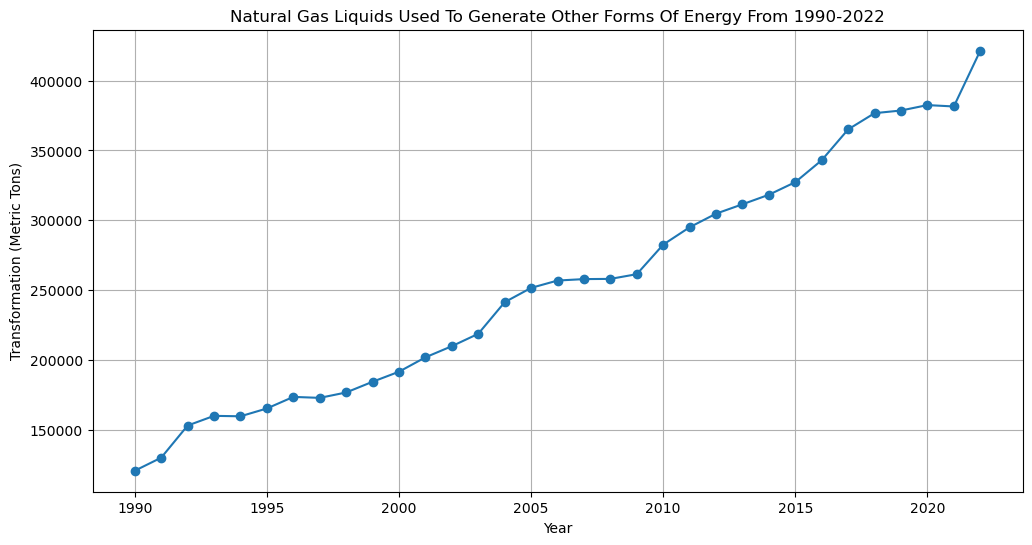

In [224]:
plt.figure(figsize=(12, 6))
plt.plot(tran_by_year.index, tran_by_year.values, marker='o')
plt.title('Natural Gas Liquids Used To Generate Other Forms Of Energy From 1990-2022')
plt.xlabel('Year')
plt.ylabel('Transformation (Metric Tons)')
plt.grid(True)
plt.show()

## Production Forecasting
Production refers to the total amount of natural gas liquids (NGLs) produced in a given year/country.

In [225]:
df_production= dataframes_by_transaction['Production']
df_production

,ref_area,year,obs_value
4,Algeria,1992,20830
5,Algeria,1995,23489
6,Algeria,2006,21911
7,Algeria,2015,18346
57,Angola,2008,683
...,...,...,...
11989,India,2002,4087
11990,India,2016,4295
11991,India,2022,3543
12002,Indonesia,1994,4436


In [226]:
print_dataframe_details(df_transaformation)

Dataset Shape:(1982, 3)

 Columns:['ref_area', 'year', 'obs_value']
<class 'pandas.core.frame.DataFrame'>
Index: 1982 entries, 0 to 11995
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ref_area   1982 non-null   string
 1   year       1982 non-null   int16 
 2   obs_value  1982 non-null   int32 
dtypes: int16(1), int32(1), string(1)
memory usage: 42.6 KB

 Info:
None

 Missing values:
ref_area     0
year         0
obs_value    0
dtype: int64

 Sample rows:
       ref_area  year  obs_value
0   Afghanistan  1990          0
22      Algeria  1991       5280
23      Algeria  1996       6039
24      Algeria  1998       9889
25      Algeria  2004      10343
26      Algeria  2020      12068
61       Angola  2005        132
62       Angola  2006        624
63       Angola  2010        535
64       Angola  2020       2336

 Duplicate rows:
0

 

UNIQUE VALUES IN EACH COLUMN
ref_area <StringArray>
[                               

In [227]:
prod_by_year= df_production.groupby('year')['obs_value'].sum()

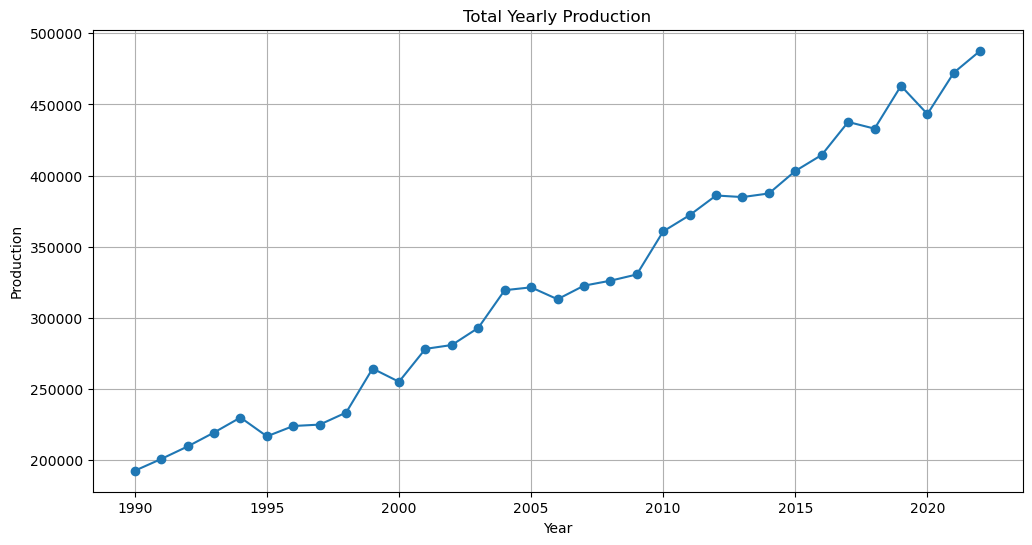

In [228]:
plt.figure(figsize=(12, 6))
plt.plot(prod_by_year.index, prod_by_year.values, marker='o')
plt.title('Total Yearly Production')
plt.xlabel('Year')
plt.ylabel('Production')
plt.grid(True)
plt.show()

In [229]:
global_prod= df_production.groupby(['year','ref_area'])['obs_value'].sum().reset_index()
top5p_countries = global_prod.groupby('ref_area')['obs_value'].sum().nlargest(5).index #get top 5
top5_prod = global_prod[global_prod['ref_area'].isin(top5p_countries)]

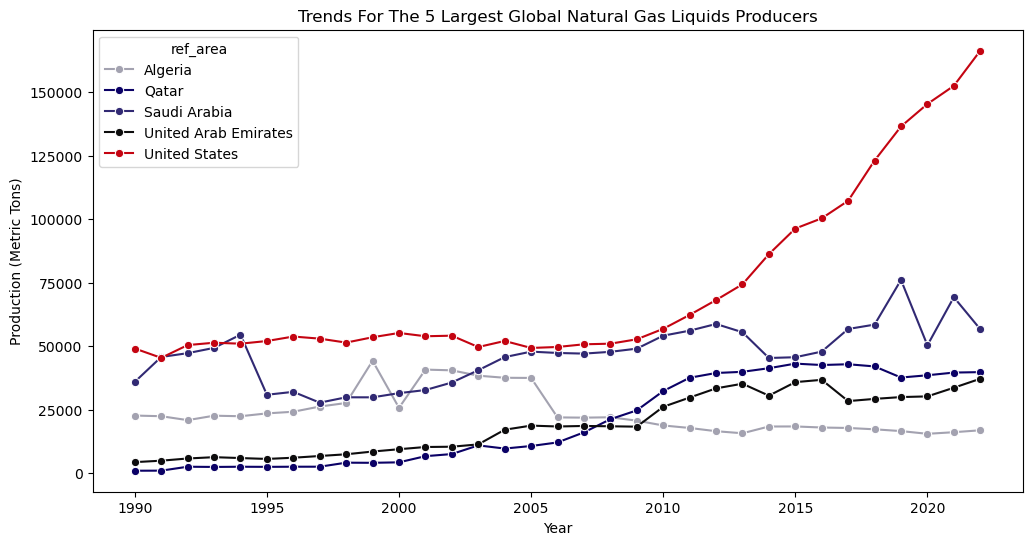

In [230]:
palette=['#a3a2b0', '#0b0166', '#312973', '#0d0c0d' , '#c40411']
plt.figure(figsize=(12,6))
sns.lineplot(data=top5_prod, x='year', y='obs_value', marker='o',hue='ref_area', palette=palette)
plt.title('Trends For The 5 Largest Global Natural Gas Liquids Producers')
plt.xlabel('Year')
plt.ylabel('Production (Metric Tons)')
plt.show()

The United States dominates global production as shown above.

## Forecasting Yearly LNG Production

In [231]:
X= np.array(prod_by_year.index).reshape(-1,1)
y= prod_by_year.values

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [233]:
lr= LinearRegression()

In [234]:
lr.fit(X_train, y_train)

LinearRegression()

In [235]:
lr.score(X_test,y_test)

0.9717479312524347

In [236]:
y_pred= lr.predict(X_test)

In [237]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error:{mse}')

Mean Squared Error:164694777.93446812


In [238]:
#the same as accuracy
r2score = r2_score(y_test, y_pred)
print(f'R2 Score:{r2score}')

R2 Score:0.9717479312524347


In [239]:
years_to_predict= np.array(range(2023,2031)).reshape(-1,1)
print(years_to_predict)

[[2023]
 [2024]
 [2025]
 [2026]
 [2027]
 [2028]
 [2029]
 [2030]]


In [240]:
predictions= np.array(lr.predict(years_to_predict))
forecast= pd.DataFrame({'Year': years_to_predict.flatten(), 'Forecast': predictions})
forecast = forecast.astype(int)

In [241]:
forecast

,Year,Forecast
0,2023,479983
1,2024,489072
2,2025,498161
3,2026,507250
4,2027,516339
5,2028,525429
6,2029,534518
7,2030,543607


In [242]:
forecast.to_csv('Liquid Natural Gas 2030 Forecast.csv')